In [22]:
import openpyxl
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor

from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

from matplotlib import pyplot as plt
import datetime
import math
import pandas as pd
from scipy import stats
import seaborn as sn

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

# Drops specific values in a dataframe
# if flag = 1, drops values less than 'val'
# if flag = 0, drops values greater than 'val'
def drop_values(dataframe, column, val, flag):
    if flag:
        return dataframe.drop(dataframe[column < val].index)
    else:
        return dataframe.drop(dataframe[column > val].index)

# Read in the sensor cluster data
sensor_cluster = pd.read_pickle('CLEANED_RAW_DATA_HOURLY_WITH_TARGET/sensor_cluster_25May2020_hourly.pkl')
# Remove the first 3 outliers
sensor_cluster = sensor_cluster.iloc[3:]
# Read in the Airpointer dataframe
airpointer = pd.read_pickle('CLEANED_RAW_DATA_HOURLY_WITH_TARGET/airpointer_25May2020_hourly.pkl')
# Remove the first 3 outliers
airpointer = airpointer.iloc[3:]

In [23]:
sensor_cluster

,Temperature[degC],Humidity[percent],PM1.0[ug/m^3],PM2.5[ug/m^3],PM10.0[ug/m^3],O3[ppb],O3[V],NO2[ppb],NO2[V],Pressure[Pa],Airpointer_NO2[ppb]
Timestamp,,,,,,,,,,,
2020-05-06 16:00:00,21.898333,19.096778,1.161667,1.975000,2.187778,52.662000,1.424325,135.239611,1.422013,99140.480000,5.137333
2020-05-06 17:00:00,21.836278,18.678667,1.469444,2.380556,2.604444,53.213833,1.424310,118.911944,1.422118,99111.335556,7.393667
2020-05-06 18:00:00,18.713167,20.979889,1.914444,2.970556,3.246667,53.447722,1.424056,98.456389,1.422115,99124.504444,10.763833
2020-05-06 19:00:00,15.544500,24.716389,2.207222,3.381667,3.666111,53.151778,1.423809,91.426611,1.422016,99156.430556,3.808167
2020-05-06 20:00:00,14.085389,23.612889,1.320000,1.861111,1.991111,49.789500,1.423761,74.300333,1.422064,99214.601111,4.448667
...,...,...,...,...,...,...,...,...,...,...,...
2020-05-25 11:00:00,39.924556,30.432944,5.115000,6.662778,6.872778,73.049333,1.425910,121.291000,1.423404,99705.132778,2.609533
2020-05-25 12:00:00,39.951111,30.081556,6.773333,8.543889,8.806111,78.604889,1.425797,136.821444,1.423287,99701.504444,6.032083
2020-05-25 13:00:00,37.129333,35.702833,10.958889,14.503889,14.927222,81.051278,1.425383,124.142611,1.423120,99690.339444,5.811367


In [24]:
airpointer

,NO,NO2,NOx,O3,PM10_conc,PM10-2.5_conc,PM2.5_conc,Air_Temperature,Relative_Humidity
Timestamp,,,,,,,,,
2020-05-06 16:00:00,1.919000,5.137333,6.889833,40.594000,19.666000,15.035500,4.626500,12.851333,26.497000
2020-05-06 17:00:00,2.494167,7.393667,9.502500,39.201833,21.422167,16.256500,5.165667,12.170000,27.646167
2020-05-06 18:00:00,1.459167,10.763833,12.104500,35.107333,16.479000,11.466000,5.013333,11.409000,28.912333
2020-05-06 19:00:00,0.409500,3.808167,4.204333,38.284333,13.103500,9.678500,3.426167,10.577667,26.920333
2020-05-06 20:00:00,0.315500,4.448667,4.764667,36.122500,10.409333,7.162833,3.244000,9.082000,28.326833
...,...,...,...,...,...,...,...,...,...
2020-05-25 11:00:00,0.365917,2.609533,2.975500,55.903200,19.268467,12.141783,7.127267,996.547950,30.645433
2020-05-25 12:00:00,0.603183,6.032083,6.635250,56.402150,25.994967,14.871600,11.122967,996.351517,28.949983
2020-05-25 13:00:00,0.628783,5.811367,6.428683,63.794417,30.028817,18.580050,11.447000,996.178783,28.876100


0.002180375476783847

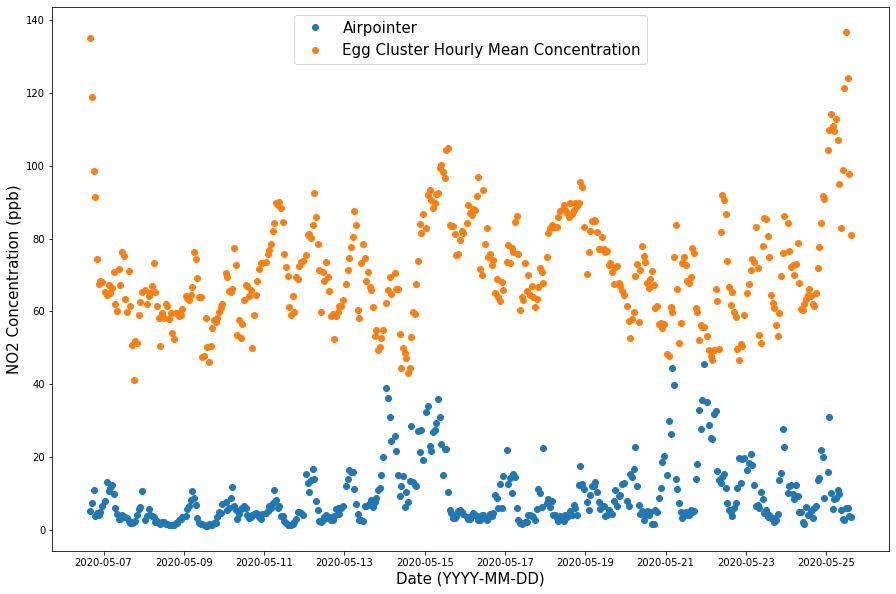

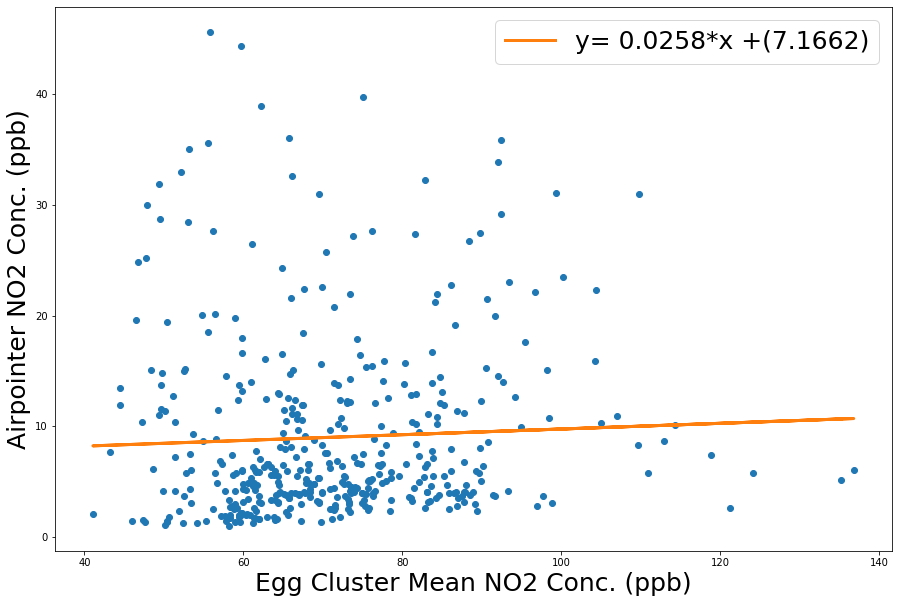

In [27]:
# Plot the time series graph
plt.figure(figsize=(15,10))
plt.plot(sensor_cluster.index.to_series(), sensor_cluster['Airpointer_NO2[ppb]'], 'o', label='Airpointer')
plt.plot(sensor_cluster.index.to_series(), sensor_cluster['NO2[ppb]'], 'o',label="Egg Cluster Hourly Mean Concentration")
plt.xlabel('Date (YYYY-MM-DD)', fontsize=15)
plt.ylabel('NO2 Concentration (ppb)', fontsize=15)
plt.legend(loc='best', fontsize=15)

# Calculate a regression line
xValues = sensor_cluster['NO2[ppb]'].to_numpy()
yValues = sensor_cluster['Airpointer_NO2[ppb]'].to_numpy()
# Calculate a regression line
linear_regression = LinearRegression().fit(xValues.reshape(-1,1), yValues)
# Plot the values graph with the regression line
plt.figure(figsize=(15,10))
plt.plot(xValues, yValues, 'o')
plt.plot(xValues, 
         linear_regression.predict(xValues.reshape(-1,1)),
         label='y= {:0.4f}*x +({:0.4f})'.format(linear_regression.coef_[0], linear_regression.intercept_),
         linewidth=3)
plt.xlabel('Egg Cluster Mean NO2 Conc. (ppb)', fontsize=25)
plt.ylabel('Airpointer NO2 Conc. (ppb)', fontsize=25)
plt.legend(loc='best', fontsize=25)

# Calculate the R2 score
metrics.r2_score(yValues, linear_regression.predict(xValues.reshape(-1,1)))

In [34]:
DATA = sensor_cluster.to_numpy()
target = sensor_cluster['Airpointer_NO2[ppb]'].to_numpy()
DATA = np.delete(DATA, 10, 1)

In [36]:
# Split the data into training and test sets
DATA_train, DATA_test, target_train, target_test = train_test_split(DATA, target, random_state=0)
# Simple Linear Regression method
elastic_net = ElasticNet(alpha=0.001, max_iter=1000000).fit(DATA_train, target_train)
print("Training set score: {:0.6f}".format(elastic_net.score(DATA_train, target_train)))
print("Test set score: {:0.6f}".format(elastic_net.score(DATA_test, target_test)))
print('MAE: {:0.4f}'.format(metrics.mean_absolute_error(target, elastic_net.predict(DATA))))
print('Estimator feature strengths: {}'.format(elastic_net.coef_))

Training set score: 0.371526
Test set score: 0.516886
MAE: 4.4949
Estimator feature strengths: [-0.17693601 -0.03643002 -1.29859049  2.38324204 -0.73963811 -0.04707808
  0.         -0.04900925  0.          0.0049269 ]


0.4071825668686526

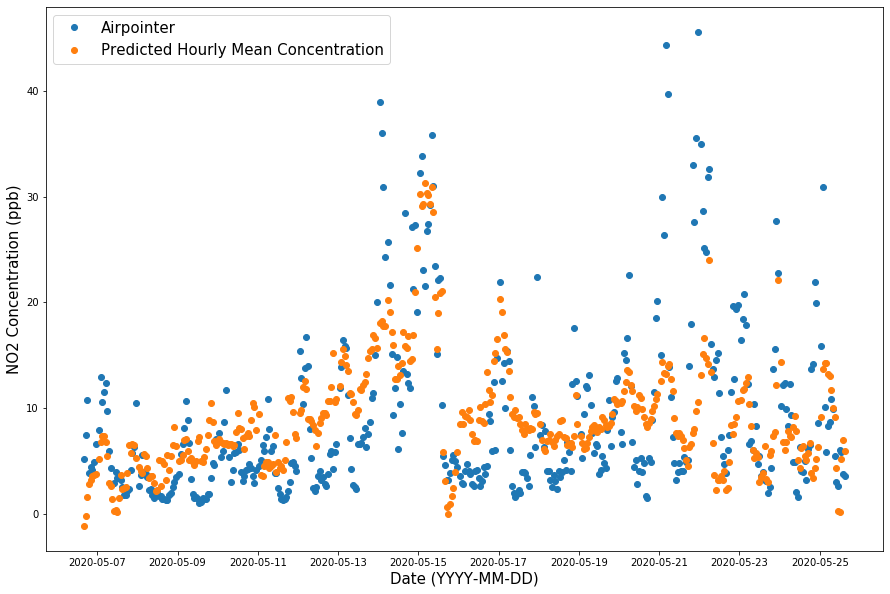

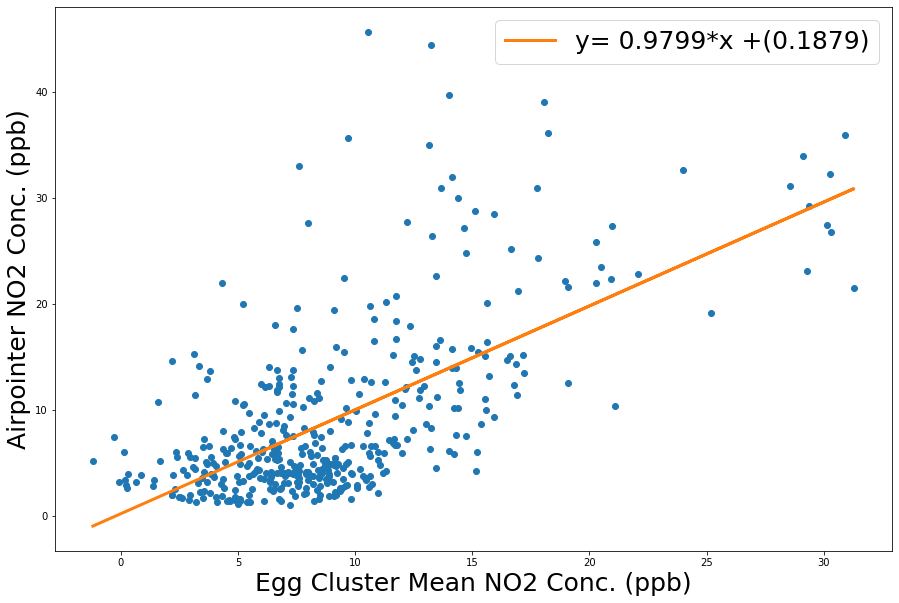

In [38]:
# Plot the time series graph
plt.figure(figsize=(15,10))
plt.plot(sensor_cluster.index.to_series(), sensor_cluster['Airpointer_NO2[ppb]'], 'o', label='Airpointer')
plt.plot(sensor_cluster.index.to_series(), elastic_net.predict(DATA), 'o',label="Predicted Hourly Mean Concentration")
plt.xlabel('Date (YYYY-MM-DD)', fontsize=15)
plt.ylabel('NO2 Concentration (ppb)', fontsize=15)
plt.legend(loc='best', fontsize=15)

# Calculate a regression line
xValues = elastic_net.predict(DATA)
yValues = sensor_cluster['Airpointer_NO2[ppb]'].to_numpy()
# Calculate a regression line
linear_regression = LinearRegression().fit(xValues.reshape(-1,1), yValues)
# Plot the values graph with the regression line
plt.figure(figsize=(15,10))
plt.plot(xValues, yValues, 'o')
plt.plot(xValues, 
         linear_regression.predict(xValues.reshape(-1,1)),
         label='y= {:0.4f}*x +({:0.4f})'.format(linear_regression.coef_[0], linear_regression.intercept_),
         linewidth=3)
plt.xlabel('Egg Cluster Mean NO2 Conc. (ppb)', fontsize=25)
plt.ylabel('Airpointer NO2 Conc. (ppb)', fontsize=25)
plt.legend(loc='best', fontsize=25)

# Calculate the R2 score
metrics.r2_score(yValues, linear_regression.predict(xValues.reshape(-1,1)))

In [42]:
sensor_cluster.head()

,Temperature[degC],Humidity[percent],PM1.0[ug/m^3],PM2.5[ug/m^3],PM10.0[ug/m^3],O3[ppb],O3[V],NO2[ppb],NO2[V],Pressure[Pa],Airpointer_NO2[ppb]
Timestamp,,,,,,,,,,,
2020-05-06 16:00:00,21.898333,19.096778,1.161667,1.975000,2.187778,52.662000,1.424325,135.239611,1.422013,99140.480000,5.137333
2020-05-06 17:00:00,21.836278,18.678667,1.469444,2.380556,2.604444,53.213833,1.424310,118.911944,1.422118,99111.335556,7.393667
2020-05-06 18:00:00,18.713167,20.979889,1.914444,2.970556,3.246667,53.447722,1.424056,98.456389,1.422115,99124.504444,10.763833
2020-05-06 19:00:00,15.544500,24.716389,2.207222,3.381667,3.666111,53.151778,1.423809,91.426611,1.422016,99156.430556,3.808167
2020-05-06 20:00:00,14.085389,23.612889,1.320000,1.861111,1.991111,49.789500,1.423761,74.300333,1.422064,99214.601111,4.448667


In [52]:
# model parameters for training
# ----------------------------------- From the Egg Sensor Cluster -----------------------------------
cluster_temp = sensor_cluster['Temperature[degC]'].to_numpy().reshape(-1,1)
cluster_humidity = sensor_cluster['Humidity[percent]'].to_numpy().reshape(-1,1)
cluster_PM1 = sensor_cluster['PM1.0[ug/m^3]'].to_numpy().reshape(-1,1)
cluster_PM25 = sensor_cluster['PM2.5[ug/m^3]'].to_numpy().reshape(-1,1)
cluster_PM10 = sensor_cluster['PM10.0[ug/m^3]'].to_numpy().reshape(-1,1)
cluster_O3_conc = sensor_cluster['O3[ppb]'].to_numpy().reshape(-1,1)
cluster_O3_vol = sensor_cluster['O3[V]'].to_numpy().reshape(-1,1)
cluster_NO2_conc = sensor_cluster['NO2[ppb]'].to_numpy().reshape(-1,1)
cluster_NO2_vol = sensor_cluster['NO2[V]'].to_numpy().reshape(-1,1)
cluster_pressure = sensor_cluster['Pressure[Pa]'].to_numpy().reshape(-1,1)

# ----------------------------------- From the Airpointer -----------------------------------
airpointer_NO = airpointer['NO'].to_numpy().reshape(-1,1)
airpointer_NO2 = airpointer['NO2'].to_numpy().reshape(-1,1)
airpointer_NOx = airpointer['NOx'].to_numpy().reshape(-1,1)
airpointer_O3 = airpointer['O3'].to_numpy().reshape(-1,1)
airpointer_PM10 = airpointer['PM10_conc'].to_numpy().reshape(-1,1)
airpointer_PM10_25 = airpointer['PM10-2.5_conc'].to_numpy().reshape(-1,1)
airpointer_PM25 = airpointer['PM2.5_conc'].to_numpy().reshape(-1,1)
airpointer_air_temp = airpointer['Air_Temperature'].to_numpy().reshape(-1,1)
airpointer_relative_humidity = airpointer['Relative_Humidity'].to_numpy().reshape(-1,1)

In [84]:
# Build the DATA matrix
DATA = np.concatenate((cluster_temp,
                       cluster_humidity,
                       cluster_PM1,
                       cluster_PM25,
                       cluster_PM10,
                       cluster_O3_conc,
                       cluster_O3_vol,
#                        cluster_NO2_conc,
#                        cluster_NO2_vol,
                       cluster_pressure,
#                        airpointer_NO,
#                        airpointer_NO2,
#                        airpointer_NOx,
                       airpointer_O3,
                       airpointer_PM10,
                       airpointer_PM10_25,
                       airpointer_PM25,
                       airpointer_air_temp,
                       airpointer_relative_humidity),axis=1)

# The target data
target = sensor_cluster['Airpointer_NO2[ppb]'].to_numpy()

In [85]:
# Split the data into training and test sets
DATA_train, DATA_test, target_train, target_test = train_test_split(DATA, target, random_state=0)
# Simple Linear Regression method
elastic_net = ElasticNet(alpha=0.001, max_iter=1000000).fit(DATA_train, target_train)
print("Training set score: {:0.6f}".format(elastic_net.score(DATA_train, target_train)))
print("Test set score: {:0.6f}".format(elastic_net.score(DATA_test, target_test)))
print('MAE: {:0.4f}'.format(metrics.mean_absolute_error(target, elastic_net.predict(DATA))))
print('Estimator feature strengths: {}'.format(elastic_net.coef_))

Training set score: 0.760826
Test set score: 0.728707
MAE: 3.0832
Estimator feature strengths: [-0.16415562 -0.15452744  0.00593638  1.83050814 -1.74239493  0.24597309
 -0.          0.0030723  -0.60235574  1.05593023 -1.04673048 -0.17128081
  0.00652226  0.0400069 ]


0.7539676287352248

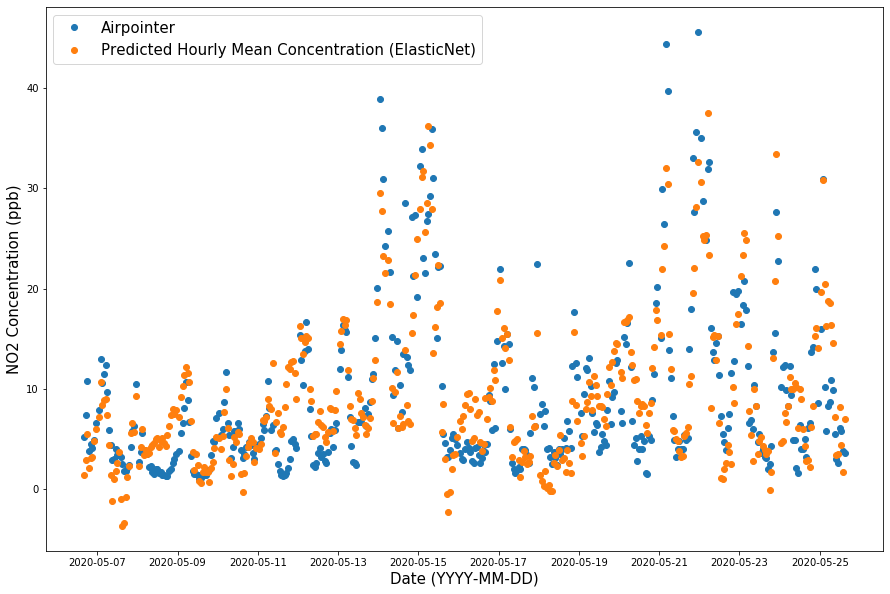

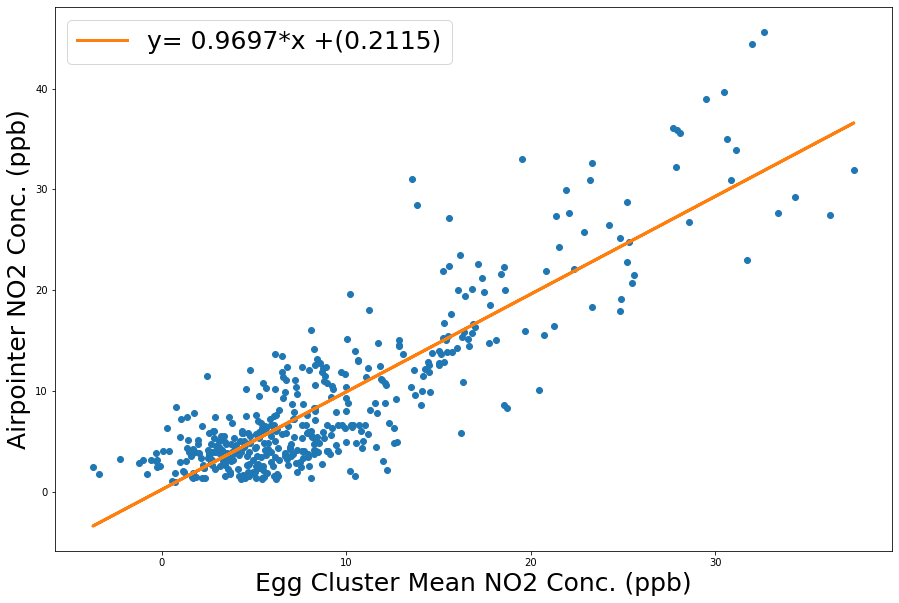

In [88]:
# Plot the time series graph
plt.figure(figsize=(15,10))
plt.plot(sensor_cluster.index.to_series(), sensor_cluster['Airpointer_NO2[ppb]'], 'o', label='Airpointer')
plt.plot(sensor_cluster.index.to_series(), elastic_net.predict(DATA), 'o',label="Predicted Hourly Mean Concentration (ElasticNet)")
plt.xlabel('Date (YYYY-MM-DD)', fontsize=15)
plt.ylabel('NO2 Concentration (ppb)', fontsize=15)
plt.legend(loc='best', fontsize=15)

# Calculate a regression line
xValues = elastic_net.predict(DATA)
yValues = sensor_cluster['Airpointer_NO2[ppb]'].to_numpy()
# Calculate a regression line
linear_regression = LinearRegression().fit(xValues.reshape(-1,1), yValues)
# Plot the values graph with the regression line
plt.figure(figsize=(15,10))
plt.plot(xValues, yValues, 'o')
plt.plot(xValues, 
         linear_regression.predict(xValues.reshape(-1,1)),
         label='y= {:0.4f}*x +({:0.4f})'.format(linear_regression.coef_[0], linear_regression.intercept_),
         linewidth=3)
plt.xlabel('Egg Cluster Mean NO2 Conc. (ppb)', fontsize=25)
plt.ylabel('Airpointer NO2 Conc. (ppb)', fontsize=25)
plt.legend(loc='best', fontsize=25)

# Calculate the R2 score
metrics.r2_score(yValues, linear_regression.predict(xValues.reshape(-1,1)))

In [101]:
# Build the DATA matrix
DATA = np.concatenate((cluster_humidity,
                       cluster_PM1,
                       cluster_PM25,
                       cluster_PM10,
#                        cluster_O3_conc,
#                        cluster_O3_vol,
#                        cluster_NO2_conc,
#                        cluster_NO2_vol,
                       cluster_pressure,
#                        airpointer_NO,
#                        airpointer_NO2,
#                        airpointer_NOx,
                       airpointer_O3
#                        airpointer_PM10,
                       #airpointer_PM25,
                      ),axis=1)

# The target data
target = sensor_cluster['Airpointer_NO2[ppb]'].to_numpy()

In [98]:
# Split the data into training and test sets
DATA_train, DATA_test, target_train, target_test = train_test_split(DATA, target, random_state=0)
# Simple Linear Regression method
decision_tree = DecisionTreeRegressor(max_depth=None, min_samples_leaf=5, random_state=0).fit(DATA_train, target_train)
print("Training set score: {:0.6f}".format(decision_tree.score(DATA_train, target_train)))
print("Test set score: {:0.6f}".format(decision_tree.score(DATA_test, target_test)))
print('MAE: {:0.4f}'.format(metrics.mean_absolute_error(target, decision_tree.predict(DATA))))
print('Estimator feature strengths: {}'.format(decision_tree.feature_importances_))

Training set score: 0.862462
Test set score: 0.710647
MAE: 2.3718
Estimator feature strengths: [0.06674574 0.05654516 0.02602242 0.01890758 0.06768281 0.76409629]


In [81]:
selector = RFE(estimator = decision_tree, step=1)
selector.fit(DATA, target)
selector.ranking_

array([7, 1, 6, 2, 8, 1, 1, 1, 1, 1, 4, 1, 3, 5])

0.82622933982665

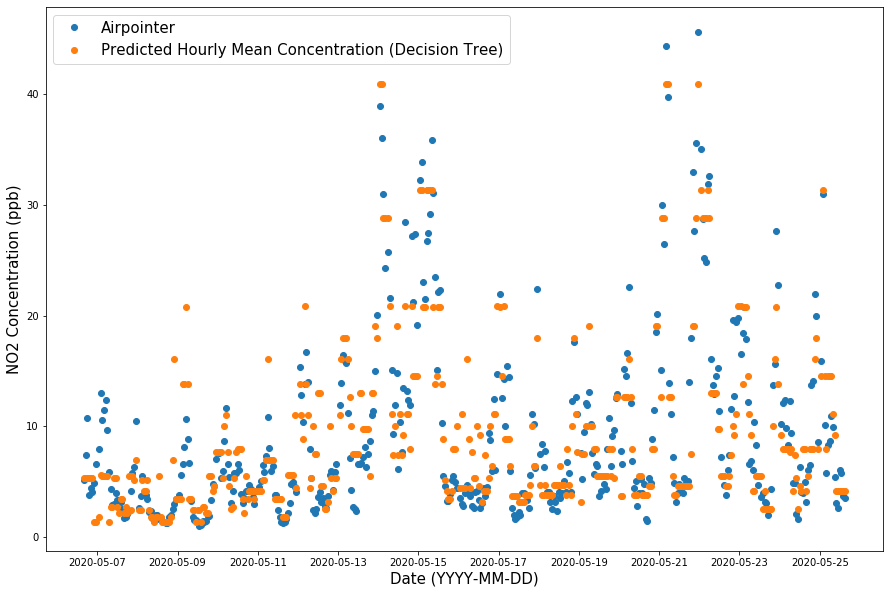

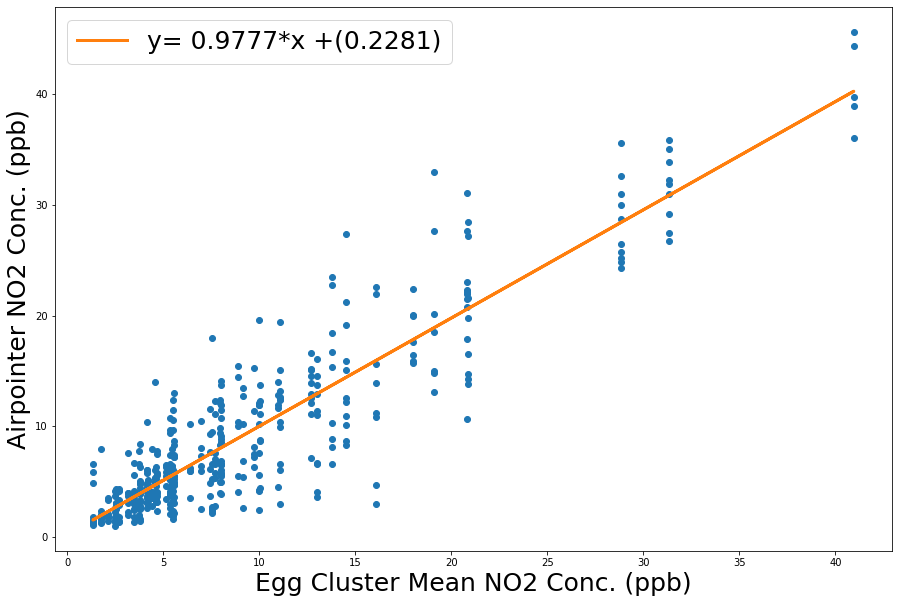

In [109]:
# Plot the time series graph
plt.figure(figsize=(15,10))
plt.plot(sensor_cluster.index.to_series(), sensor_cluster['Airpointer_NO2[ppb]'], 'o', label='Airpointer')
plt.plot(sensor_cluster.index.to_series(), decision_tree.predict(DATA), 'o',label="Predicted Hourly Mean Concentration (Decision Tree)")
plt.xlabel('Date (YYYY-MM-DD)', fontsize=15)
plt.ylabel('NO2 Concentration (ppb)', fontsize=15)
plt.legend(loc='best', fontsize=15)

# Calculate a regression line
xValues = decision_tree.predict(DATA)
yValues = sensor_cluster['Airpointer_NO2[ppb]'].to_numpy()
# Calculate a regression line
linear_regression = LinearRegression().fit(xValues.reshape(-1,1), yValues)
# Plot the values graph with the regression line
plt.figure(figsize=(15,10))
plt.plot(xValues, yValues, 'o')
plt.plot(xValues, 
         linear_regression.predict(xValues.reshape(-1,1)),
         label='y= {:0.4f}*x +({:0.4f})'.format(linear_regression.coef_[0], linear_regression.intercept_),
         linewidth=3)
plt.xlabel('Egg Cluster Mean NO2 Conc. (ppb)', fontsize=25)
plt.ylabel('Airpointer NO2 Conc. (ppb)', fontsize=25)
plt.legend(loc='best', fontsize=25)

# Calculate the R2 score
metrics.r2_score(yValues, linear_regression.predict(xValues.reshape(-1,1)))

In [113]:
# Make the training dataframe
training_dataframe = pd.DataFrame()
training_dataframe['Cluster_Humidity[percent]'] = sensor_cluster['Humidity[percent]']
training_dataframe['Cluster_PM1.0[ug/m^3]'] = sensor_cluster['PM1.0[ug/m^3]']
training_dataframe['Cluster_PM2.5[ug/m^3]'] = sensor_cluster['PM2.5[ug/m^3]']
training_dataframe['Cluster_PM10.0[ug/m^3]'] = sensor_cluster['PM10.0[ug/m^3]']
training_dataframe['Cluster_Pressure[Pa]'] = sensor_cluster['Pressure[Pa]']
training_dataframe['Airpointer_O3[ppb]'] = airpointer['O3']
training_dataframe['Target_Airpointer_NO2[ppb]'] = sensor_cluster['Airpointer_NO2[ppb]']

training_dataframe

,Cluster_Humidity[percent],Cluster_PM1.0[ug/m^3],Cluster_PM2.5[ug/m^3],Cluster_PM10.0[ug/m^3],Cluster_Pressure[Pa],Airpointer_O3[ppb],Target_Airpointer_NO2[ppb]
Timestamp,,,,,,,
2020-05-06 16:00:00,19.096778,1.161667,1.975000,2.187778,99140.480000,40.594000,5.137333
2020-05-06 17:00:00,18.678667,1.469444,2.380556,2.604444,99111.335556,39.201833,7.393667
2020-05-06 18:00:00,20.979889,1.914444,2.970556,3.246667,99124.504444,35.107333,10.763833
2020-05-06 19:00:00,24.716389,2.207222,3.381667,3.666111,99156.430556,38.284333,3.808167
2020-05-06 20:00:00,23.612889,1.320000,1.861111,1.991111,99214.601111,36.122500,4.448667
...,...,...,...,...,...,...,...
2020-05-25 11:00:00,30.432944,5.115000,6.662778,6.872778,99705.132778,55.903200,2.609533
2020-05-25 12:00:00,30.081556,6.773333,8.543889,8.806111,99701.504444,56.402150,6.032083
2020-05-25 13:00:00,35.702833,10.958889,14.503889,14.927222,99690.339444,63.794417,5.811367


In [114]:
training_dataframe.to_pickle('training_dataframe.pkl')

In [115]:
training_dataframe = pd.read_pickle('training_dataframe.pkl')
training_dataframe

,Cluster_Humidity[percent],Cluster_PM1.0[ug/m^3],Cluster_PM2.5[ug/m^3],Cluster_PM10.0[ug/m^3],Cluster_Pressure[Pa],Airpointer_O3[ppb],Target_Airpointer_NO2[ppb]
Timestamp,,,,,,,
2020-05-06 16:00:00,19.096778,1.161667,1.975000,2.187778,99140.480000,40.594000,5.137333
2020-05-06 17:00:00,18.678667,1.469444,2.380556,2.604444,99111.335556,39.201833,7.393667
2020-05-06 18:00:00,20.979889,1.914444,2.970556,3.246667,99124.504444,35.107333,10.763833
2020-05-06 19:00:00,24.716389,2.207222,3.381667,3.666111,99156.430556,38.284333,3.808167
2020-05-06 20:00:00,23.612889,1.320000,1.861111,1.991111,99214.601111,36.122500,4.448667
...,...,...,...,...,...,...,...
2020-05-25 11:00:00,30.432944,5.115000,6.662778,6.872778,99705.132778,55.903200,2.609533
2020-05-25 12:00:00,30.081556,6.773333,8.543889,8.806111,99701.504444,56.402150,6.032083
2020-05-25 13:00:00,35.702833,10.958889,14.503889,14.927222,99690.339444,63.794417,5.811367


In [120]:
training_dataframe = pd.read_pickle('training_dataframe.pkl')
DATA = training_dataframe.to_numpy()
target = DATA[:,6]
DATA = np.delete(DATA, 6, 1)

In [121]:
decision_tree = DecisionTreeRegressor(max_depth=None, min_samples_leaf=5, random_state=0).fit(DATA, target)
print("Training set score: {:0.6f}".format(decision_tree.score(DATA, target)))
print('MAE: {:0.4f}'.format(metrics.mean_absolute_error(target, decision_tree.predict(DATA))))
print('Estimator feature strengths: {}'.format(decision_tree.feature_importances_))

Training set score: 0.888656
MAE: 1.8721
Estimator feature strengths: [0.08159988 0.06040589 0.02791685 0.00991461 0.08213074 0.73803204]
